# Prep

Setting up some prior functionality

In [1]:
import os
import glob
import json
from PIL import Image
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())

1.5.1+cu101 True


# Dataset

Our dataset should be loadable as a COCO format

This allows us to use the pycocotools to load the data dict for the main python script

In [3]:
# alternatively, implement your own coco-type dataset loader in datasets and add this "key" to datasets/__init__.py
dataset_file = "coco_petct" 

# should lead to a directory with a train2017 and val2017 folder as well as an annotations folder
#dataDir='/COCO_dataset/' 
#dataDir = '/media/storage/Joy/datasets/DETR_MIP/FDG-PET-CT-Lesions/'
# dataDir = '/gpfs/fs0/data/stanford_data/petct/DETR_MIP/FDG-PET-CT-Lesions/'
dataDir = '/gpfs/fs0/data/stanford_data/petct/DETR_MIP2/FDG-PET-CT-Lesions/'

# this int should be the actual number of classes + 1 (for no class)
num_classes = 2

outDir = 'outputs'


In [4]:
!ls /gpfs/fs0/data/stanford_data/petct/DETR_MIP2/FDG-PET-CT-Lesions/annotations/

detr_test.json	detr_train.json  detr_val.json


In [5]:
!ls $dataDir

annotations  images


# Visualize

In [6]:
%matplotlib inline
import pycocotools.coco as coco
from pycocotools.coco import COCO
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
import pylab
from pathlib import Path
from PIL import Image
pylab.rcParams['figure.figsize'] = (10.0, 8.0)

In [7]:
mode = 'train'
annFile='{}annotations/detr_{}.json'.format(dataDir,mode)
print(annFile)

# https://github.com/cocodataset/cocoapi/blob/master/PythonAPI/pycocotools/coco.py
# initialize COCO api for instance annotations
coco=COCO(annFile)

/gpfs/fs0/data/stanford_data/petct/DETR_MIP2/FDG-PET-CT-Lesions/annotations/detr_train.json
loading annotations into memory...
Done (t=2.14s)
creating index...
index created!


In [8]:
# display COCO categories and supercategories
cats = coco.loadCats(coco.getCatIds())

nms=[cat['name'] for cat in cats]
print('Categories: {}'.format(nms))

nms = set([cat['supercategory'] for cat in cats])
print('Super-categories: {}'.format(nms))

Categories: ['background', 'tumor']
Super-categories: {'tumor', 'background'}


In [9]:
# load and display image
catIds = coco.getCatIds(catNms=['tumor']);
imgIds = coco.getImgIds(catIds=catIds );

In [10]:
def _load_image_npy(coco, img_folder, img_id):
    npy_name = coco.loadImgs(img_id)[0]["file_name"] # loads a .npy file by image_id
    img_ann_path = img_folder/Path(npy_name)
    print(img_ann_path)
    with open(img_ann_path, 'rb') as f:
        suv_img = np.load(f) # this is a single channel suv values image, dtype numpy float64
    return suv_img

def _suv_to_greyPIL(suv_img, suv_max):
    # Assuming eval mode
    norm = plt.Normalize(vmin = 0, vmax = suv_max) # normally radiologists view images at this suv norm
    # Color map to gray images, output has 3 channels
    cmap = plt.cm.Greys
    img = cmap(norm(suv_img))[:,:,:3].copy() # drop the alpha channel that we don't need. has shape (H x W x 3C) 
    #img = torch.as_tensor(img, dtype=torch.float64) # the transforms latera will turn the numpy array to a tensor (C x H x W)
    img = Image.fromarray(np.uint8(img*255), 'RGB') # expected input by transforms
    return img

     

Image n°0
Image name: /gpfs/fs0/data/stanford_data/petct/DETR_MIP2/FDG-PET-CT-Lesions//annotations/train/0.npy
/gpfs/fs0/data/stanford_data/petct/DETR_MIP2/FDG-PET-CT-Lesions/images/train/0.npy


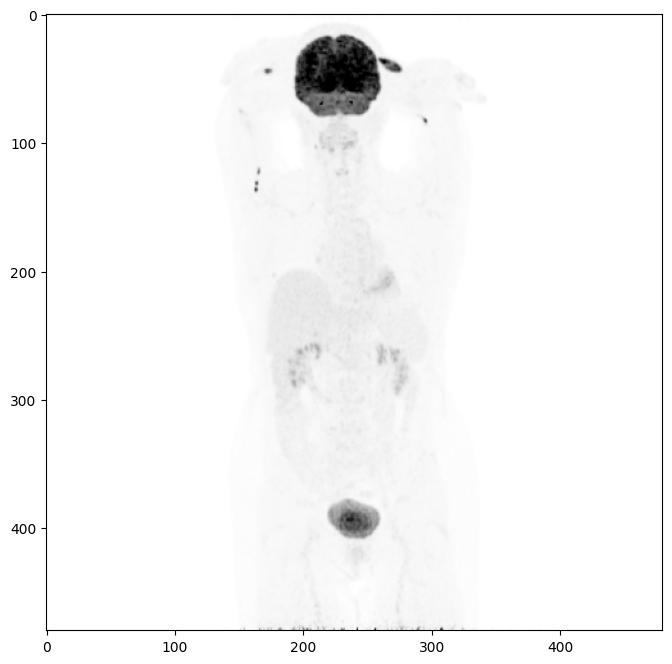

In [11]:
#img_id = imgIds[np.random.randint(0,len(imgIds))]
img_id = 0
print('Image n°{}'.format(img_id))

img = coco.loadImgs(img_id)[0]

img_name = '%s/%s/%s/%s'%(dataDir, 'annotations', mode, img['file_name'])
print('Image name: {}'.format(img_name))

img_folder = Path(dataDir)/Path('images')/Path(mode)
suv_img = _load_image_npy(coco, img_folder, img_id)
suv_max = 20
I = _suv_to_greyPIL(suv_img, suv_max)

#I = io.imread(img_name)
plt.figure()
plt.imshow(I)

In [12]:
annIds = coco.getAnnIds(imgIds=img['id'], catIds=catIds)
anns = coco.loadAnns(annIds)

print(len(anns))

5


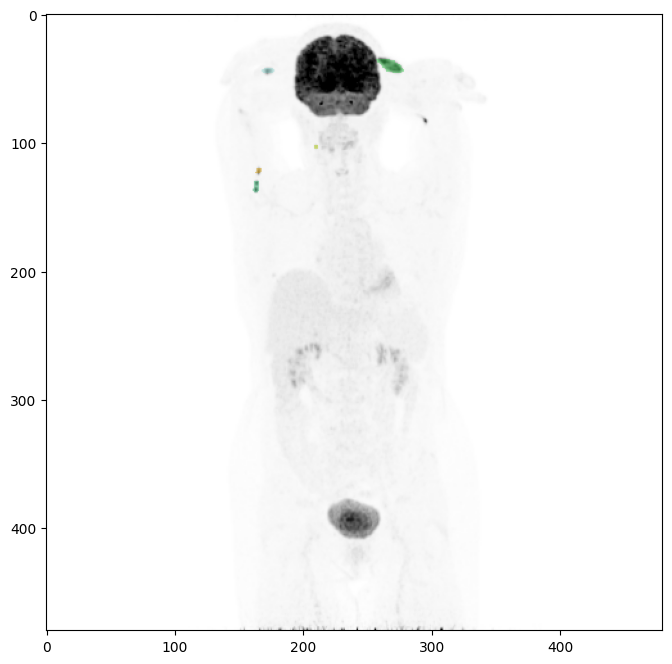

In [13]:
# load and display instance annotations
plt.imshow(I)
coco.showAnns(anns, draw_bbox=False)

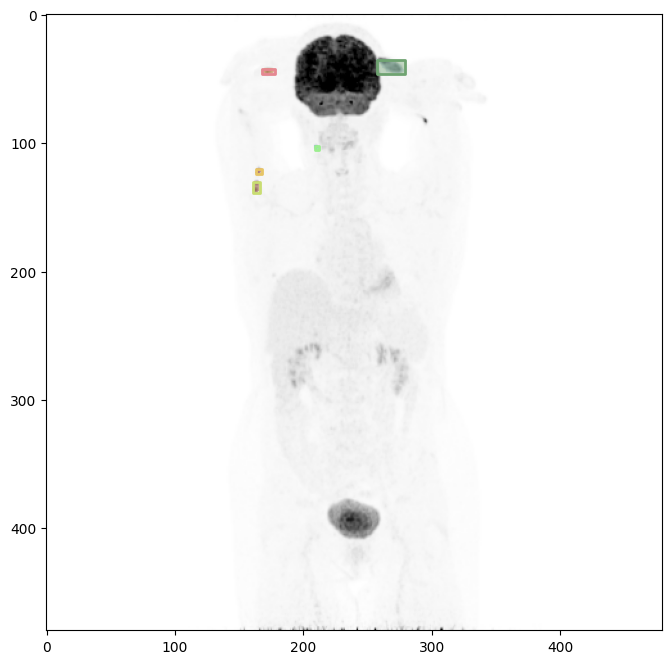

In [14]:
plt.imshow(I)
coco.showAnns(anns, draw_bbox=True)

# Dataset Statistics

### Almost all images have < 100 objects

i.e. Makes sense to keep object queries to 100.

In [15]:
max_anno = 0
min_anno = 1
freq_anno = []
for imgID in imgIds:
    annIds = coco.getAnnIds(imgIds=imgID, catIds=[1])
    anns = coco.loadAnns(annIds)
    num = len(anns)
    if num > max_anno:
        max_anno = num
    if num < min_anno:
        min_anno = num
    if num > 1:
        freq_anno.append(num)
print(max_anno) 
print(min_anno) 
print(len(freq_anno))
print(len([f for f in freq_anno if f < 50]))

261
1
15955
15580


(array([2.777e+03, 2.514e+03, 1.679e+03, 1.556e+03, 1.015e+03, 8.130e+02,
        7.420e+02, 6.010e+02, 5.460e+02, 4.300e+02, 2.880e+02, 2.400e+02,
        1.160e+02, 1.230e+02, 1.520e+02, 1.600e+02, 1.310e+02, 1.330e+02,
        1.090e+02, 8.500e+01, 8.900e+01, 9.300e+01, 7.100e+01, 8.000e+01,
        7.300e+01, 8.500e+01, 8.000e+01, 8.000e+01, 8.200e+01, 6.200e+01,
        4.200e+01, 3.000e+01, 1.700e+01, 3.000e+01, 3.100e+01, 4.200e+01,
        3.100e+01, 3.000e+01, 5.000e+01, 3.200e+01, 3.900e+01, 4.200e+01,
        3.400e+01, 3.500e+01, 2.700e+01, 2.000e+01, 1.700e+01, 2.600e+01,
        2.300e+01, 2.300e+01, 1.700e+01, 1.400e+01, 2.500e+01, 2.100e+01,
        7.000e+00, 6.000e+00, 2.000e+00, 1.000e+01, 7.000e+00, 7.000e+00,
        1.100e+01, 4.000e+00, 1.600e+01, 1.300e+01, 1.000e+01, 1.400e+01,
        7.000e+00, 3.000e+00, 4.000e+00, 5.000e+00, 5.000e+00, 6.000e+00,
        4.000e+00, 4.000e+00, 5.000e+00, 6.000e+00, 1.300e+01, 5.000e+00,
        3.000e+00, 4.000e+00, 2.000e+0

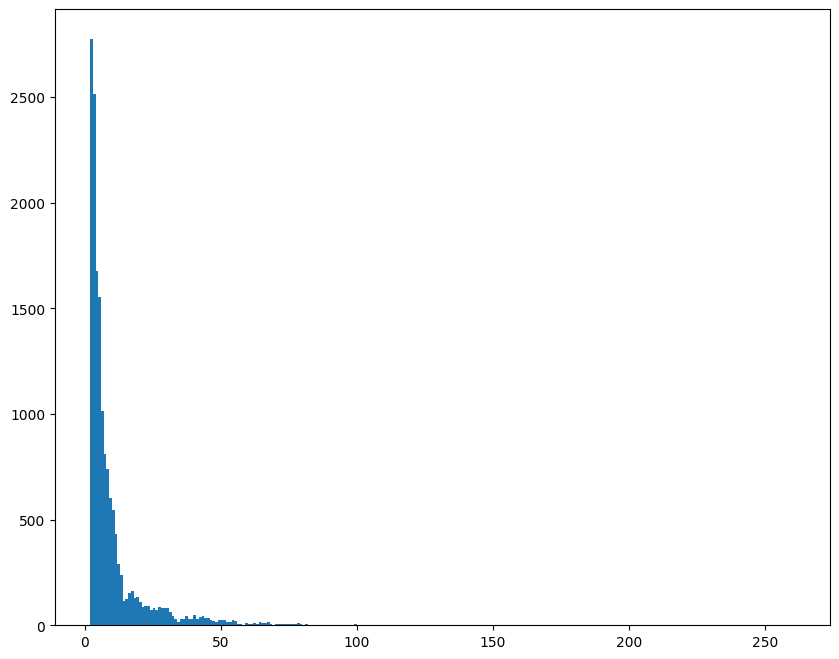

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from numpy import *

data = np.asarray(freq_anno)
plt.hist(data, bins=np.arange(data.min(), data.max()+1))


In [17]:
print('Number of images with more than 100 tumor lesions:',len([f for f in freq_anno if f > 100]))

Number of images with more than 100 tumor lesions: 55


### Small, medium and large objects likely different for petct datset

https://github.com/cocodataset/cocoapi/issues/325

In [18]:
areas = []
AnnIds = coco.getAnnIds(catIds=catIds)
print(len(AnnIds))

annotations = coco.loadAnns(ids=AnnIds)
print(len(annotations))
print(annotations[0])

for ann in annotations: # {'annot_id...': {'area',...}, }
    area = ann['area']
    areas.append(area)
    
print(len(areas))
sizes = [np.sqrt(a) for a in areas]

161716
161716
{'image_id': 0, 'id': 0, 'segmentation': {'counts': [123395, 1, 479, 3, 477, 3, 477, 4, 476, 5, 475, 7, 473, 7, 473, 8, 472, 10, 470, 10, 470, 10, 471, 9, 471, 9, 471, 10, 470, 10, 472, 8, 472, 8, 473, 7, 473, 7, 474, 6, 476, 3, 478, 2, 96915], 'size': [480, 480]}, 'area': 147, 'iscrowd': 0, 'bbox': [257, 35, 22, 11], 'category_id': 1}
161716


(array([8.3780e+03, 1.7409e+04, 1.8601e+04, 1.9154e+04, 1.7318e+04,
        1.4347e+04, 1.0809e+04, 8.2030e+03, 6.4720e+03, 5.3630e+03,
        4.0700e+03, 3.4710e+03, 2.7080e+03, 2.0280e+03, 2.0400e+03,
        1.4350e+03, 1.2500e+03, 1.2840e+03, 1.2160e+03, 1.2670e+03,
        1.1240e+03, 7.9400e+02, 7.6400e+02, 7.6200e+02, 6.9000e+02,
        5.2900e+02, 6.3000e+02, 5.5600e+02, 5.7100e+02, 4.7500e+02,
        5.1700e+02, 5.5000e+02, 4.4000e+02, 3.4200e+02, 3.8000e+02,
        3.2300e+02, 3.3500e+02, 3.3600e+02, 3.3100e+02, 3.1600e+02,
        3.2500e+02, 3.3100e+02, 2.4800e+02, 1.7400e+02, 1.4300e+02,
        1.8700e+02, 1.5200e+02, 1.1200e+02, 8.4000e+01, 9.1000e+01,
        1.4700e+02, 1.4900e+02, 1.7400e+02, 1.3700e+02, 1.4300e+02,
        1.2700e+02, 1.2700e+02, 9.7000e+01, 7.6000e+01, 9.7000e+01,
        8.3000e+01, 6.8000e+01, 4.1000e+01, 3.4000e+01, 2.4000e+01,
        2.8000e+01, 2.8000e+01, 4.2000e+01, 2.7000e+01, 3.2000e+01,
        2.2000e+01, 2.7000e+01, 2.3000e+01, 1.70

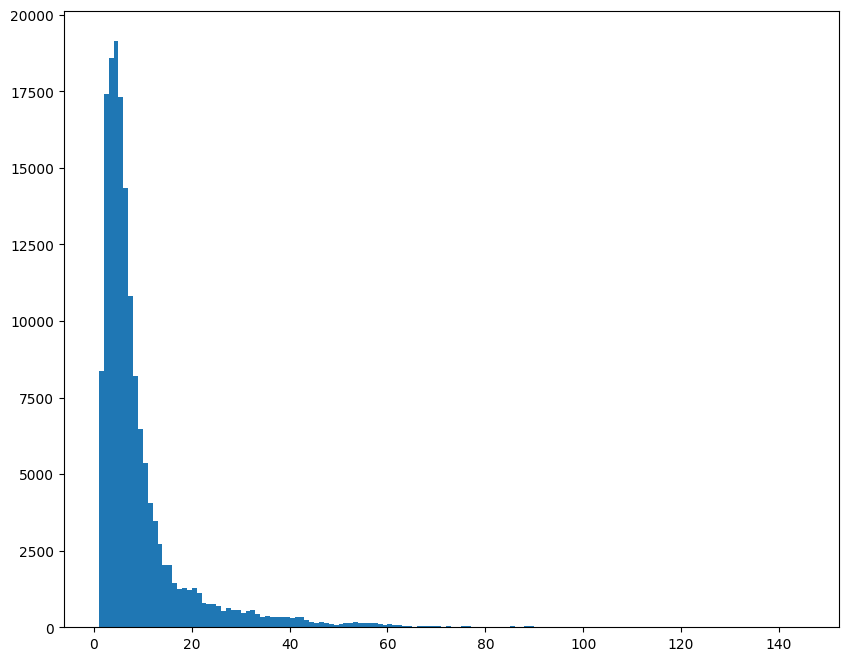

In [19]:
data = np.asarray(sizes)
plt.hist(data, bins=np.arange(data.min(), data.max()+1))

In [20]:
print('A good split for sizes of objects would be:')
print('Small (0**2 to {}**2):'.format(4), len([s for s in sizes if s < 4 ])/len(sizes))
print('Medium ({}**2 to {}**2):'.format(4,8), len([s for s in sizes if (s >= 4)&(s < 8) ])/len(sizes))
print('Large ({}**2 to 1e5**2):'.format(8), len([s for s in sizes if s >= 8 ])/len(sizes))

A good split for sizes of objects would be:
Small (0**2 to 4**2): 0.2744811892453437
Medium (4**2 to 8**2): 0.3810878329911697
Large (8**2 to 1e5**2): 0.3444309777634866


# Results

Quick and easy overview of the training results

https://github.com/woctezuma/finetune-detr/blob/master/finetune_detr.ipynb

In [21]:
from util.plot_utils import plot_logs, plot_precision_recall

from pathlib import Path

experiment = 'baseline'

log_directory = [Path(outDir)/Path(experiment)]

/home/joywu/detr/util/plot_utils.py:67: FutureWarning: Dropping of nuisance columns in rolling operations is deprecated; in a future version this will raise TypeError. Select only valid columns before calling the operation. Dropped columns were Index(['test_coco_eval_bbox'], dtype='object')
  df.interpolate().ewm(com=ewm_col).mean().plot(


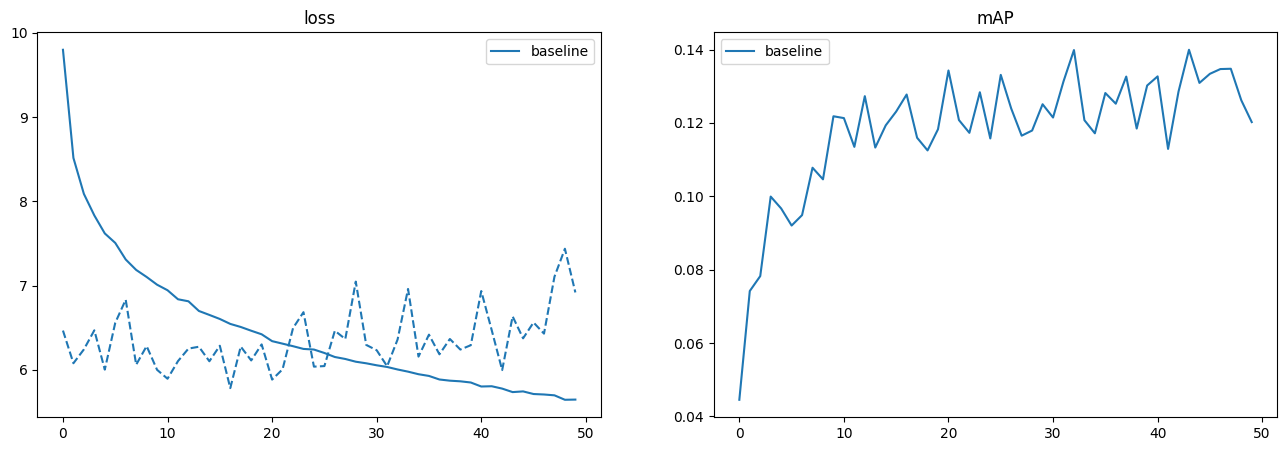

In [22]:
fields_of_interest = (
    'loss',
    'mAP',
    )

plot_logs(log_directory,
          fields_of_interest)

/home/joywu/detr/util/plot_utils.py:67: FutureWarning: Dropping of nuisance columns in rolling operations is deprecated; in a future version this will raise TypeError. Select only valid columns before calling the operation. Dropped columns were Index(['test_coco_eval_bbox'], dtype='object')
  df.interpolate().ewm(com=ewm_col).mean().plot(
/home/joywu/detr/util/plot_utils.py:67: FutureWarning: Dropping of nuisance columns in rolling operations is deprecated; in a future version this will raise TypeError. Select only valid columns before calling the operation. Dropped columns were Index(['test_coco_eval_bbox'], dtype='object')
  df.interpolate().ewm(com=ewm_col).mean().plot(
/home/joywu/detr/util/plot_utils.py:67: FutureWarning: Dropping of nuisance columns in rolling operations is deprecated; in a future version this will raise TypeError. Select only valid columns before calling the operation. Dropped columns were Index(['test_coco_eval_bbox'], dtype='object')
  df.interpolate().ewm(com

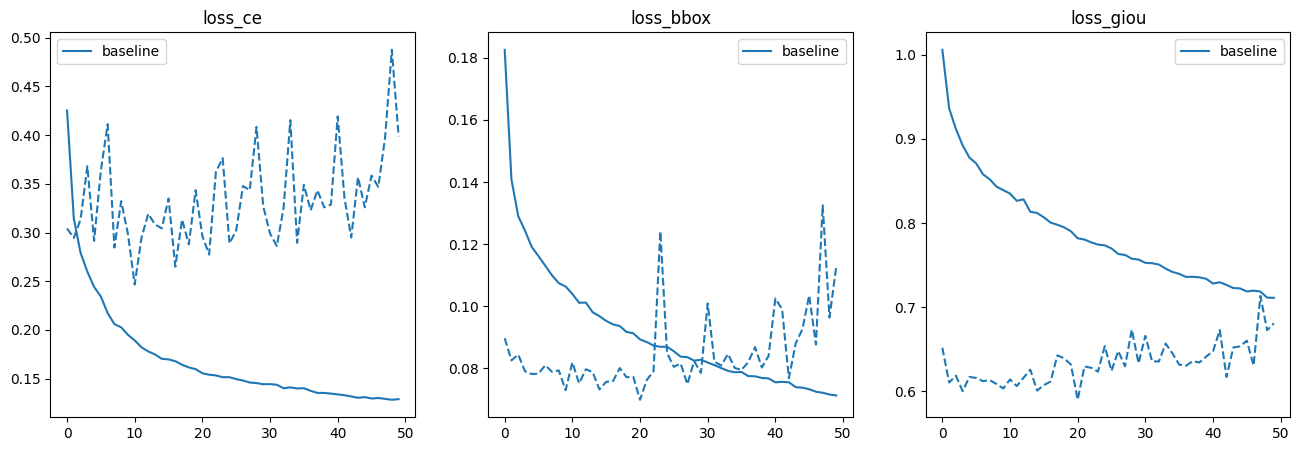

In [23]:
fields_of_interest = (
    'loss_ce',
    'loss_bbox',
    'loss_giou',
    )

plot_logs(log_directory,
          fields_of_interest)

/home/joywu/detr/util/plot_utils.py:67: FutureWarning: Dropping of nuisance columns in rolling operations is deprecated; in a future version this will raise TypeError. Select only valid columns before calling the operation. Dropped columns were Index(['test_coco_eval_bbox'], dtype='object')
  df.interpolate().ewm(com=ewm_col).mean().plot(
/home/joywu/detr/util/plot_utils.py:67: FutureWarning: Dropping of nuisance columns in rolling operations is deprecated; in a future version this will raise TypeError. Select only valid columns before calling the operation. Dropped columns were Index(['test_coco_eval_bbox'], dtype='object')
  df.interpolate().ewm(com=ewm_col).mean().plot(


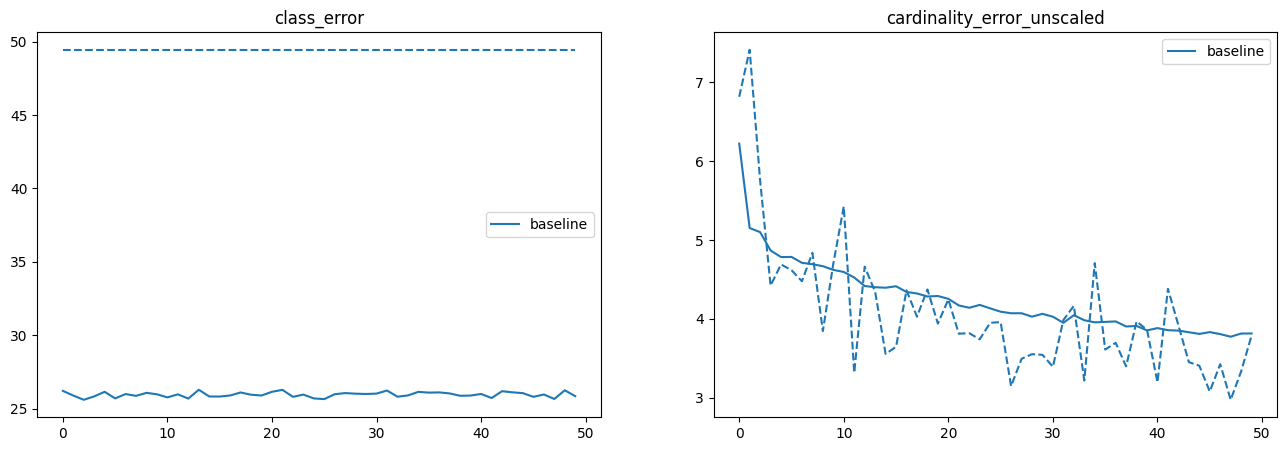

In [24]:
fields_of_interest = (
    'class_error',
    'cardinality_error_unscaled',
    )

plot_logs(log_directory,
          fields_of_interest)   

outputs/baseline/eval
[PosixPath('outputs/baseline/eval/000.pth'), PosixPath('outputs/baseline/eval/latest.pth')]
iter 000: mAP@50= 04.5, score=0.131, f1=0.070
iter latest: mAP@50= 12.0, score=0.169, f1=0.151


(<Figure size 1600x500 with 2 Axes>,
 array([<AxesSubplot: title={'center': 'Precision / Recall'}>,
        <AxesSubplot: title={'center': 'Scores / Recall'}>], dtype=object))

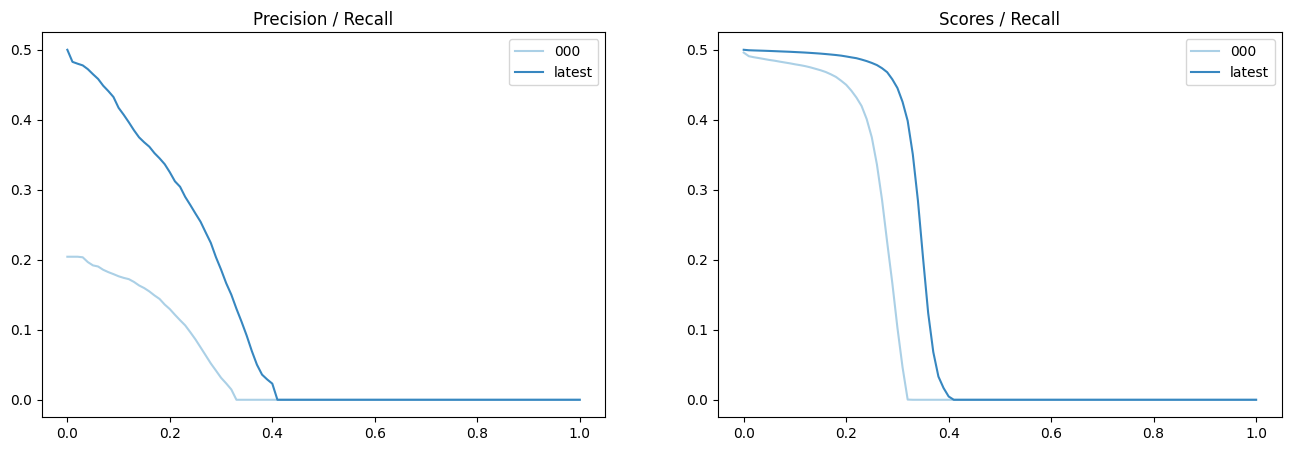

In [25]:
files = Path(outDir)/Path(experiment)/Path('eval')
print(files)
files = list(files.glob('*.pth'))
print(files)

plot_precision_recall(files)

# Visualize Inference

In [26]:
import torchvision.transforms as T

# standard PyTorch mean-std input image normalization
transform = T.Compose([
    T.Resize(800),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# colors for visualization
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]

finetuned_classes = [
      'N/A', 'tumor',
  ]

In [27]:
model = torch.hub.load('facebookresearch/detr',
                       'detr_resnet50',
                       pretrained=False,
                       num_classes=num_classes)

experiment = 'baseline'
checkpoint = torch.load('outputs/{}/checkpoint.pth'.format(experiment),
                        map_location='cpu')

model.load_state_dict(checkpoint['model'],
                      strict=False)

model.eval();
     

Using cache found in /home/joywu/.cache/torch/hub/facebookresearch_detr_master


In [28]:
def plot_finetuned_results(pil_img, prob=None, boxes=None, labels = True):
    plt.figure(figsize=(16,10))
    plt.imshow(pil_img)
    ax = plt.gca()
    colors = COLORS * 100
    if prob is not None and boxes is not None:
        for p, (xmin, ymin, xmax, ymax), c in zip(prob, boxes.tolist(), colors):
            ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                    fill=False, color=c, linewidth=3))   
            if labels:
                cl = p.argmax()
                #print('#', cl,'##', p)
                text = f'{finetuned_classes[cl]}: {p[cl]:0.2f}'
                ax.text(xmin, ymin, text, fontsize=8,
                      bbox=dict(facecolor='yellow', alpha=0.5))
    plt.axis('off')
    plt.show()
    

def interpolate_show_PET(nda, suv_max, spacing=(1,1), title=None, margin=0, dpi=100, colormap='Greys', OUTPATH=None,show=False):
    ysize = nda.shape[0]
    xsize = nda.shape[1]

    figsize = (1 + margin) * xsize * spacing[0] / dpi, (1 + margin) * ysize * spacing[1] / dpi

    fig = plt.figure(title, figsize=figsize, dpi=dpi)
    ax = fig.add_axes([margin, margin, 1 - 2 * margin, 1 - 2 * margin])
    #hide axis
    ax.axis('off')
    
    extent = (0, xsize * spacing[0], 0, ysize * spacing[1])

    #various papers mentions bicubic interpolation...
    t = ax.imshow(
#         nda, extent=extent, interpolation="hamming", cmap="Greys", origin="upper", vmax=suv_max
#         nda, extent=extent, interpolation="bilinear", cmap="Greys", origin="upper", vmax=suv_max
        nda, extent=extent, interpolation="bicubic", cmap=colormap, origin="upper", vmax=suv_max 
    )

    if title:
        plt.title(title)
    if OUTPATH != None:
        fig.savefig(os.path.join(OUTPATH,'MIP'+'%04d' % (i)+'.png'), dpi = dpi)
    if not show:
        plt.close(fig)


def box_cxcywh_to_xyxy(x):
    x_c, y_c, w, h = x.unbind(1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h),
         (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b, dim=1)


def rescale_bboxes(out_bbox, size):
    img_w, img_h = size
    b = box_cxcywh_to_xyxy(out_bbox)
    b = b * torch.tensor([img_w, img_h, img_w, img_h], dtype=torch.float32)
    return b


def filter_bboxes_from_outputs(outputs, threshold=0.7):
  
    # keep only predictions with confidence above threshold
    probas = outputs['pred_logits'].softmax(-1)[0, :, :-1]
    keep = probas.max(-1).values > threshold

    probas_to_keep = probas[keep]

    # convert boxes from [0; 1] to image scales
    bboxes_scaled = rescale_bboxes(outputs['pred_boxes'][0, keep], im.size)

    return probas_to_keep, bboxes_scaled


def run_workflow(my_image, my_model, thresholds = [0.9, 0.7], labels = True):
    # mean-std normalize the input image (batch-size: 1)
    img = transform(my_image).unsqueeze(0)

    # propagate through the model
    outputs = my_model(img)

    for threshold in thresholds:
        print('Threshold:', threshold)
        
        probas_to_keep, bboxes_scaled = filter_bboxes_from_outputs(outputs, threshold=threshold)

        plot_finetuned_results(my_image, probas_to_keep, bboxes_scaled, labels = labels)

## Display a train image

In [29]:
!ls /gpfs/fs0/data/stanford_data/petct/DETR_MIP2/FDG-PET-CT-Lesions/images/

test  train  val


In [30]:
dataDir = '/gpfs/fs0/data/stanford_data/petct/DETR_MIP2/FDG-PET-CT-Lesions/'

In [31]:
mode = 'train'
annFile='{}annotations/detr_{}.json'.format(dataDir,mode)

# initialize COCO api for instance annotations
coco=COCO(annFile)

loading annotations into memory...
Done (t=2.45s)
creating index...
index created!


In [32]:
catIds = coco.getCatIds(catNms=['tumor']);
imgIds = coco.getImgIds(catIds=catIds );

In [33]:
idx = 0
img_id = imgIds[idx*48] # the augmented dataset has 48 frames for each PET/CT study.
print(img_id)

img = coco.loadImgs(img_id)[0]
annIds = coco.getAnnIds(imgIds=img['id'], catIds=catIds)
anns = coco.loadAnns(annIds)
print(len(anns))

0
5


In [34]:
# img_name = '/content/data/custom/train2017/145053828_e0e748717c_b.jpg'
# im = Image.open(img_name)
img_folder = Path(dataDir)/Path('images')/Path('train')
suv_img = _load_image_npy(coco, img_folder, img_id)
suv_max = 6
im = _suv_to_greyPIL(suv_img, suv_max)

/gpfs/fs0/data/stanford_data/petct/DETR_MIP2/FDG-PET-CT-Lesions/images/train/0.npy


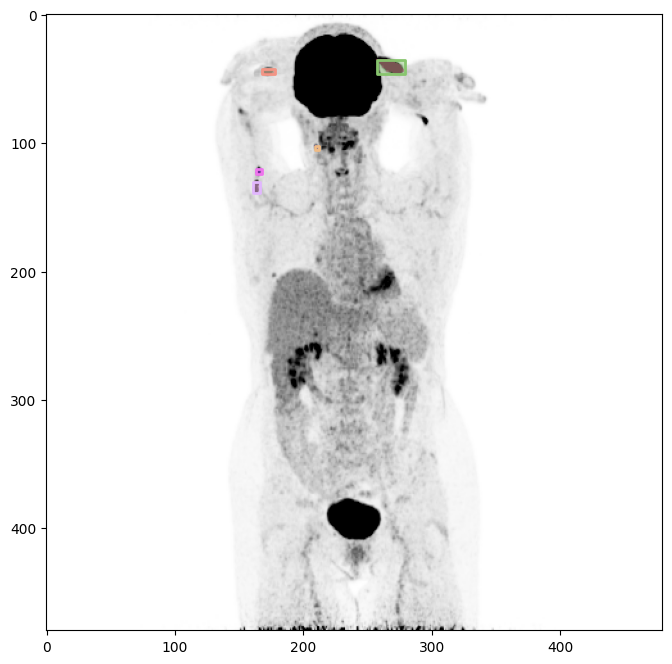

In [35]:
plt.imshow(im)
coco.showAnns(anns, draw_bbox=True)

Threshold: 0.9


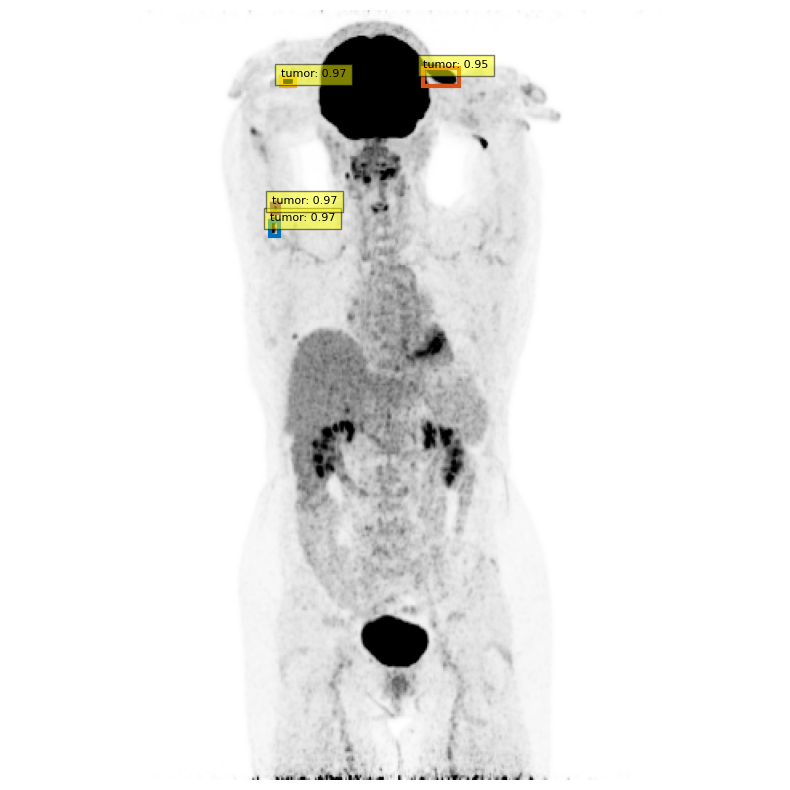

Threshold: 0.7


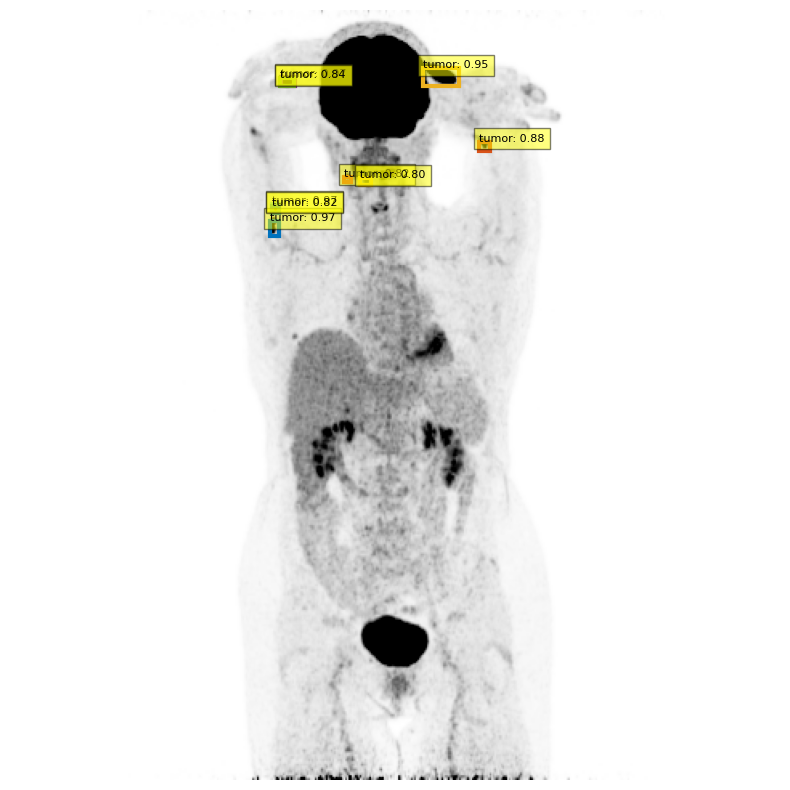

In [36]:
run_workflow(im, model)

## Display a validation image

In [37]:
mode = 'val'
annFile='{}annotations/detr_{}.json'.format(dataDir,mode)

# initialize COCO api for instance annotations
coco=COCO(annFile)

loading annotations into memory...
Done (t=0.14s)
creating index...
index created!


In [38]:
catIds = coco.getCatIds(catNms=['tumor']);
imgIds = coco.getImgIds(catIds=catIds );

In [39]:
idx = 5
img_id = imgIds[idx*48] 
print(img_id)

img = coco.loadImgs(img_id)[0]
annIds = coco.getAnnIds(imgIds=img['id'], catIds=catIds)
anns = coco.loadAnns(annIds)
print(len(anns))

41424
1


In [40]:
# img_name = '/content/data/custom/val2017/410488422_5f8991f26e_b.jpg'
# im = Image.open(img_name)
img_folder = Path(dataDir)/Path('images')/Path('val')
suv_img = _load_image_npy(coco, img_folder, img_id)
suv_max = 6
im = _suv_to_greyPIL(suv_img, suv_max)

/gpfs/fs0/data/stanford_data/petct/DETR_MIP2/FDG-PET-CT-Lesions/images/val/41424.npy


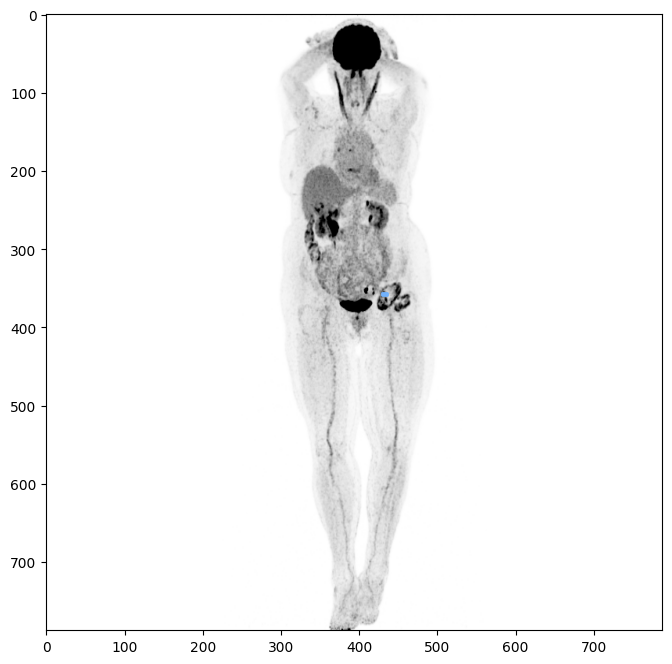

In [41]:
plt.imshow(im)
coco.showAnns(anns, draw_bbox=True)

Threshold: 0.1


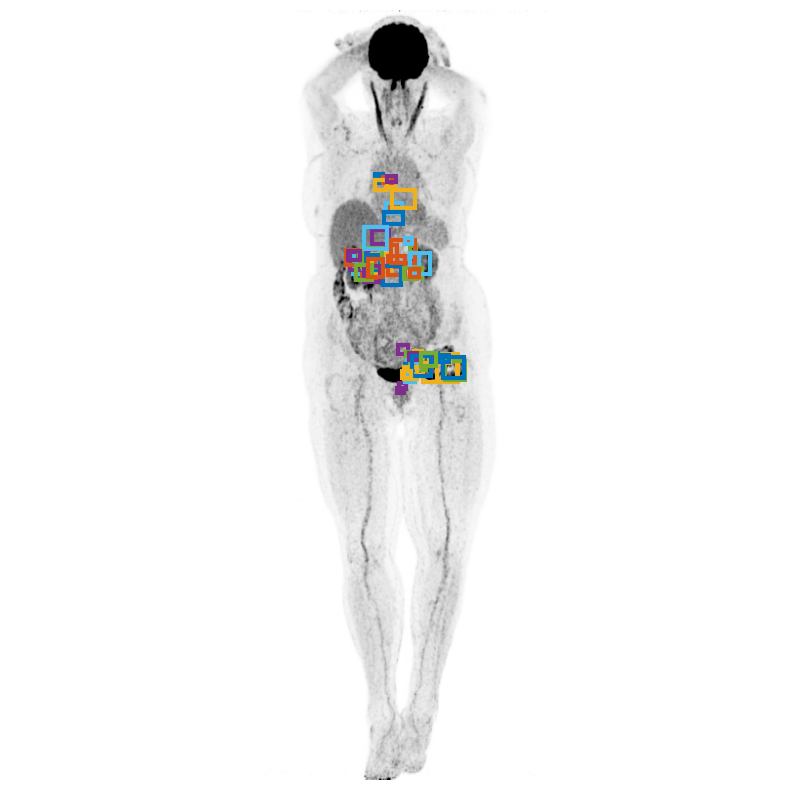

Threshold: 0.3


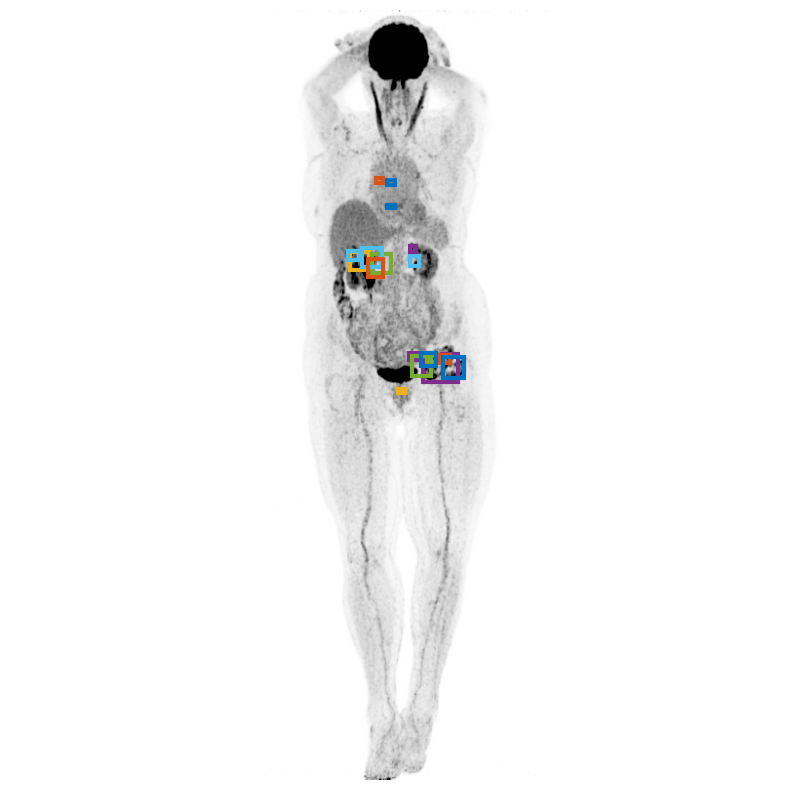

Threshold: 0.5


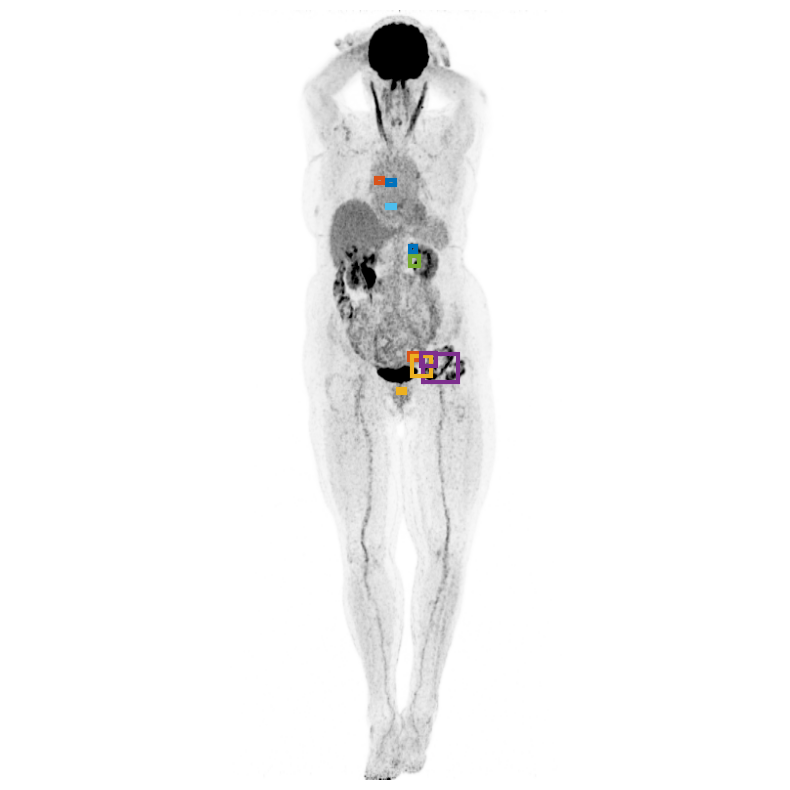

Threshold: 0.7


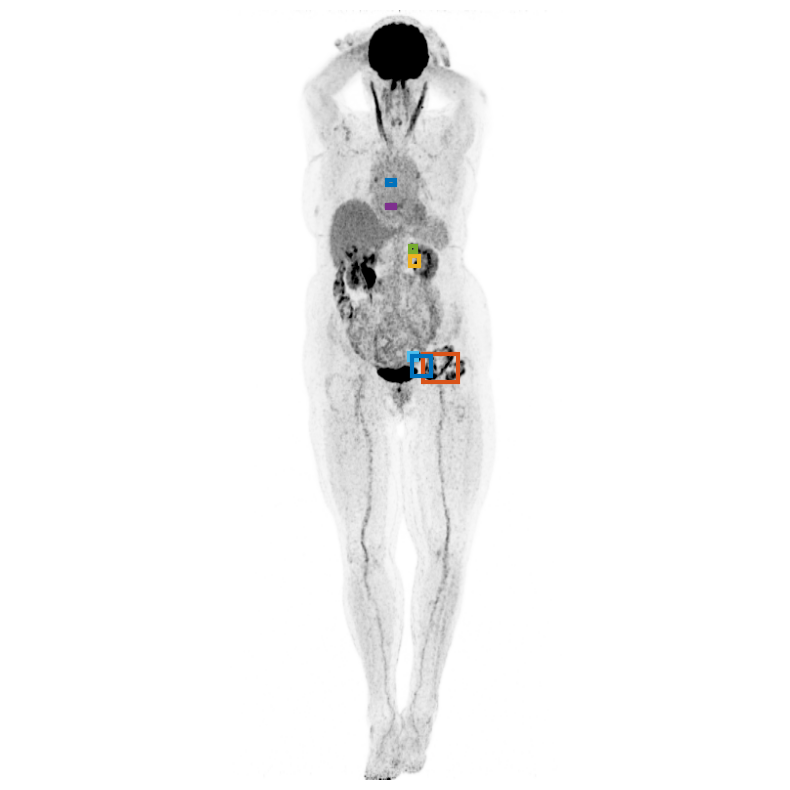

Threshold: 0.9


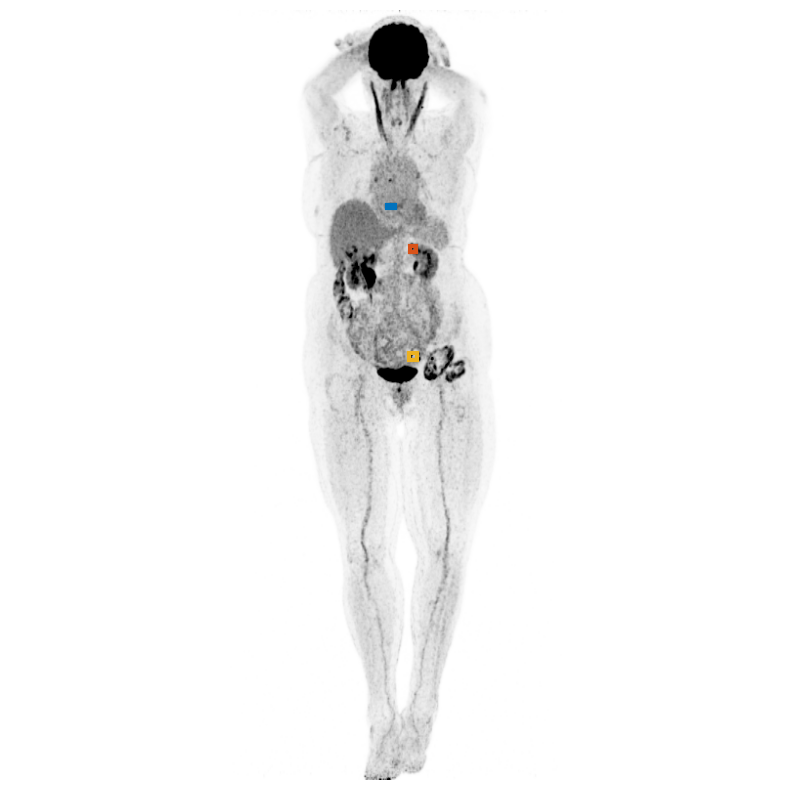

In [42]:
run_workflow(im, model, thresholds = [0.1, 0.3, 0.5, 0.7, 0.9], labels = False)

Threshold: 0.6


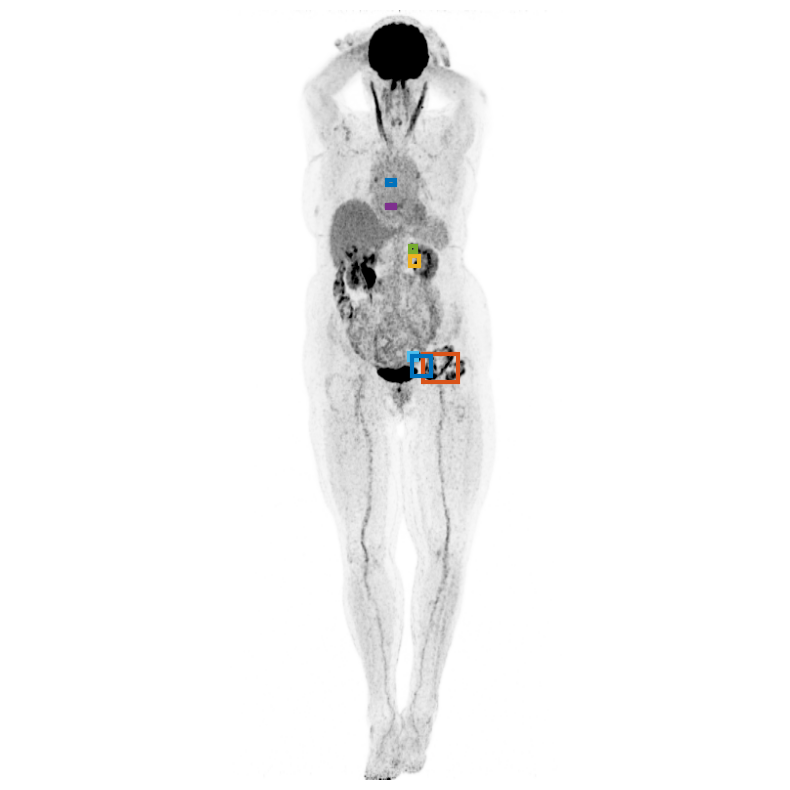

Threshold: 0.9


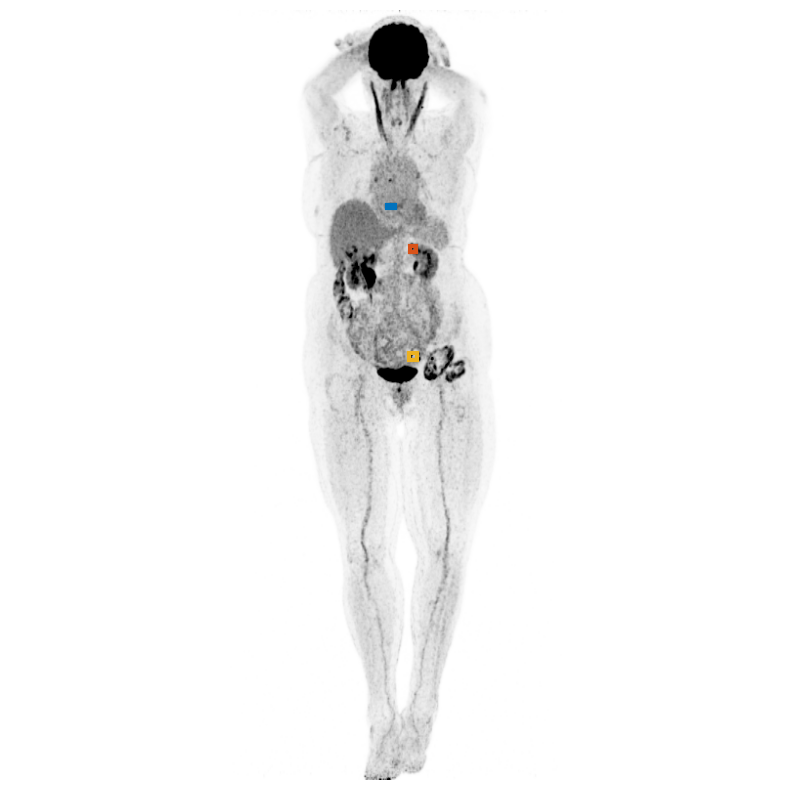

In [43]:
run_workflow(im, model, thresholds = [0.6, 0.9], labels = False)

# Next Steps

Observations:
1. Despite minimal improvement in train and val loss with additional epochs, the model still seems to have learned since epoch 1.
2. Model has not yet learn to focus on high yield areas (e.g. lymph node stations). 
3. Model still gets confused with some physiological activity that human can differentiate with PET images alone.
4. Partially identified lesions likely relates with internal SUV intensity heterogeneity within some lesions. This is a feature encoding problem.
5. Model erring on sensitive side for tumor detection currently. It does not have an "other class" label to learn about.
6. Model seems to fail to detect even at low thresholds when even human have low confidence and would need CT for confirmation.
7. I may have changed too many parameters for DETR even for the baseline experiment.
8. The Tubingen ground truth isn't 100% correct.

Implications:
* This model can be a baseline for a Q/A lesion proposal data curation pipeline to combine with the eye tracking work.
* This is likely a better baseline objects proposal model than using just maximal suppression algorithm.
* Not clear tuning whole model is a good idea with a small dataset. Should try p or prompt tuning.